In [1]:
import numpy as np
import re
from collections import Counter

In [2]:
class word2vec():
    def __init__ (self):
        self.n = settings['n']
        self.eta = settings['learning_rate']
        self.epochs = settings['epochs']
        self.window = settings['window_size']
        self.num_word = settings['num_word']
        pass


    # GENERATE TRAINING DATA
    def generate_training_data(self, settings, corpus):

        # GENERATE WORD COUNTS
        word_counts = dict(sorted(Counter(sum(sentences,[])).items(), key=lambda item: item[1],reverse=True))

        self.v_count = min(len(word_counts.keys()), self.num_word)

        # GENERATE LOOKUP DICTIONARIES
        self.words_list = list(word_counts.keys())
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list[:self.v_count]))
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list[:self.v_count]))

        training_data = []
        # CYCLE THROUGH EACH SENTENCE IN CORPUS
        for sentence in corpus:
            sent_len = len(sentence)

            # CYCLE THROUGH EACH WORD IN SENTENCE
            for i, word in enumerate(sentence):
                #w_target  = sentence[i]
                if sentence[i] in self.word_index :
                  w_target =   self.word_index[sentence[i]]

                  # CYCLE THROUGH CONTEXT WINDOW
                  w_context = []
                  for j in range(i-self.window, i+self.window+1):
                      if j!=i and j<=sent_len-1 and j>=0 and (sentence[j] in self.word_index):
                          w_context.append(self.word_index[sentence[j]])
                  if w_context != [] :
                    training_data.append([w_target, w_context])
        return np.array(training_data, dtype=object)


    # SOFTMAX ACTIVATION FUNCTION
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)


    # CONVERT WORD TO ONE HOT ENCODING
    def word2onehot(self, word):
        word_vec = [0 for i in range(0, self.v_count)]
        word_vec[word] = 1
        return word_vec


    # FORWARD PASS
    def forward_pass(self, x):
        #h = np.dot(self.w1.T, x)
        h=self.w1[x]
        u = np.dot(self.w2.T, h)
        y_c = self.softmax(u)
        return y_c, h, u


    # BACKPROPAGATION
    def backprop(self, e, h, x):
        dl_dw1 = np.dot(self.w2, e)
        dl_dw2 = np.outer(h, e)


        # UPDATE WEIGHTS
        self.w1[x] = self.w1[x] - (self.eta * dl_dw1)
        self.w2 = self.w2 - (self.eta * dl_dw2)
        # print(self.w1.shape, dl_dw1.shape, self.w2.shape, dl_dw2.shape)
        pass


    # TRAIN W2V model
    def train(self,training_data):
        # INITIALIZE WEIGHT MATRICES
        self.w1 = np.random.uniform(-0.8, 0.8, (self.v_count, self.n))     # embedding matrix
        self.w2 = np.random.uniform(-0.8, 0.8, (self.n, self.v_count))     # context matrix
        #train_leng= len(training_data)
        # CYCLE THROUGH EACH EPOCH
        self.losses = []
        for i in range(0, self.epochs):
            #counter =0
            self.loss = 0
            # CYCLE THROUGH EACH TRAINING SAMPLE
            for t, c in training_data:
                #w_t=self.word2onehot(t)
                w_c=[]
                for j in c:
                  w_c.append(self.word2onehot(j))
                #counter+=1
                #print(counter/train_leng)
                # FORWARD PASS
                y_pred, h, u = self.forward_pass(t)

                # CALCULATE ERROR
                EI = np.subtract( y_pred *len(w_c),np.sum(w_c, axis=0))

                # BACKPROPAGATION
                self.backprop(EI, h, t)

                # CALCULATE LOSS
                self.loss += -np.sum([u[j] for j in c]) + len(w_c) * np.log(np.sum(np.exp(u)))

            #self.loss += -2*np.log(len(w_c)) -np.sum([u[word.index(1)] for word in w_c]) + (len(w_c) * np.log(np.sum(np.exp(u))))
            self.losses.append(self.loss)
            print ('EPOCH:',i, 'LOSS:', self.loss)
        pass


    # input a word, returns a vector (if available)
    def word_vec(self, word):
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
        return v_w


    # input a vector, returns nearest word(s)
    def vec_sim(self, vec, top_n):

        # CYCLE THROUGH VOCAB
        word_sim = {}
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_num = np.dot(vec, v_w2)
            theta_den = np.linalg.norm(vec) * np.linalg.norm(v_w2)
            theta = theta_num / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda item: item[1], reverse=True)

        for word, sim in words_sorted[:top_n]:
            print (word, sim)

        pass

    # input word, returns top [n] most similar words
    def word_sim(self, word, top_n):

        w1_index = self.word_index[word]
        v_w1 = self.w1[w1_index]

        # CYCLE THROUGH VOCAB
        word_sim = {}
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_num = np.dot(v_w1, v_w2)
            theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
            theta = theta_num / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda item: item[1], reverse=True)

        for word, sim in words_sorted[:top_n]:
            print (word, sim)

        pass

In [3]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
settings = {}
settings['n'] = 50                  # dimension of word embeddings
settings['window_size'] = 5         # context window +/- center word
# settings['min_count'] = 2         # minimum word count
settings['epochs'] = 25             # number of training epochs
# settings['neg_samp'] = 10         # number of negative words to use during training
settings['learning_rate'] = 0.05    # learning rate
settings['num_word'] = 1000         # Number of the most frequent unique words
np.random.seed(0)                   # set the seed for reproducibility

# Import file
corpus_raw = ''
text_data = open("./alice.txt", "r",encoding='unicode_escape')
for line in text_data.readlines():
  corpus_raw += line
text_data.close()
corpus_raw = corpus_raw.lower()

stop_words = set(stopwords.words('english'))
sentences = []
raw_sentences = re.split(r"[.,]", corpus_raw)
for sentence in raw_sentences:
  if sentence != '':
    tem = re.sub(r'[^\w\s]', '', sentence)
    temp = re.sub("[^a-zA-Z]"," ", tem).split()
    sent = []
    for word in temp:
      if word in stop_words:
        continue
      else:
        sent.append(word)
    if len(sent) > 1:
      sentences.append(sent)


In [11]:
# INITIALIZE W2V MODEL
w2v = word2vec()

# generate training data
training_data = w2v.generate_training_data(settings, sentences)

# train word2vec model
w2v.train(training_data)

EPOCH: 0 LOSS: 255102.83911193302
EPOCH: 1 LOSS: 218029.91351965658
EPOCH: 2 LOSS: 204870.59481425319
EPOCH: 3 LOSS: 196585.78223150256
EPOCH: 4 LOSS: 190558.1339556373
EPOCH: 5 LOSS: 186051.82779156012
EPOCH: 6 LOSS: 182649.05341515632
EPOCH: 7 LOSS: 180043.0936360589
EPOCH: 8 LOSS: 178013.61779159232
EPOCH: 9 LOSS: 176405.1354971942
EPOCH: 10 LOSS: 175110.7030541821
EPOCH: 11 LOSS: 174054.1916102928
EPOCH: 12 LOSS: 173180.84313008684
EPOCH: 13 LOSS: 172450.9091669846
EPOCH: 14 LOSS: 171835.0833531646
EPOCH: 15 LOSS: 171311.20207268395
EPOCH: 16 LOSS: 170862.02910101973
EPOCH: 17 LOSS: 170474.0151239095
EPOCH: 18 LOSS: 170136.45836481222
EPOCH: 19 LOSS: 169840.95866453
EPOCH: 20 LOSS: 169580.88513890834
EPOCH: 21 LOSS: 169350.96647420197
EPOCH: 22 LOSS: 169146.90034667027
EPOCH: 23 LOSS: 168965.18930458813
EPOCH: 24 LOSS: 168802.8670132958


In [12]:
w2v.word_sim("alice", 10)

alice 0.9999999999999999
decidedly 0.5178927577927134
angrily 0.5076996142361893
said 0.4592544409528137
nervous 0.4392888574568768
air 0.42759187952087924
mean 0.42573933404431746
doors 0.4247877849118797
king 0.4247825003575683
puzzled 0.4164874230659222


In [13]:
import pandas as pd
import seaborn as sns
losses= w2v.losses

In [14]:
print(losses)

[255102.83911193302, 218029.91351965658, 204870.59481425319, 196585.78223150256, 190558.1339556373, 186051.82779156012, 182649.05341515632, 180043.0936360589, 178013.61779159232, 176405.1354971942, 175110.7030541821, 174054.1916102928, 173180.84313008684, 172450.9091669846, 171835.0833531646, 171311.20207268395, 170862.02910101973, 170474.0151239095, 170136.45836481222, 169840.95866453, 169580.88513890834, 169350.96647420197, 169146.90034667027, 168965.18930458813, 168802.8670132958]


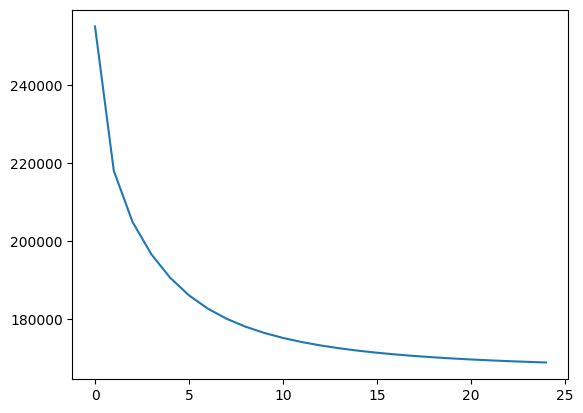

In [15]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [17]:
w2v.word_sim("queen", 10)

queen 1.0
playing 0.5726733827874645
players 0.4858696402099616
sentence 0.4683005708914219
shrill 0.4478213274076884
reply 0.43713570237765387
rabbit 0.4367039455375735
unfortunate 0.43172741823311755
silent 0.42111936399281186
shes 0.4188618663492833


In [18]:
w2v.word_sim("king", 10)

king 1.0000000000000002
sleepy 0.4991703923749641
said 0.4799455464445272
angry 0.47772198562393065
twinkling 0.46740668717349676
guessed 0.46111223710970656
begins 0.4597458610831442
white 0.44167740500538355
hoarse 0.43612887744924284
interrupted 0.4302008590601845
